Epoch 1/100
2089/2089 - 7s - loss: 1.1287e-04 - 7s/epoch - 3ms/step
Epoch 2/100
2089/2089 - 5s - loss: 4.5560e-05 - 5s/epoch - 2ms/step
Epoch 3/100
2089/2089 - 4s - loss: 3.9334e-05 - 4s/epoch - 2ms/step
Epoch 4/100
2089/2089 - 5s - loss: 3.6777e-05 - 5s/epoch - 3ms/step
Epoch 5/100
2089/2089 - 4s - loss: 3.7634e-05 - 4s/epoch - 2ms/step
Epoch 6/100
2089/2089 - 4s - loss: 2.9677e-05 - 4s/epoch - 2ms/step
Epoch 7/100
2089/2089 - 5s - loss: 2.8427e-05 - 5s/epoch - 3ms/step
Epoch 8/100
2089/2089 - 4s - loss: 3.0985e-05 - 4s/epoch - 2ms/step
Epoch 9/100
2089/2089 - 5s - loss: 2.6137e-05 - 5s/epoch - 2ms/step
Epoch 10/100
2089/2089 - 5s - loss: 2.5466e-05 - 5s/epoch - 2ms/step
Epoch 11/100
2089/2089 - 4s - loss: 2.4578e-05 - 4s/epoch - 2ms/step
Epoch 12/100
2089/2089 - 5s - loss: 2.5724e-05 - 5s/epoch - 3ms/step
Epoch 13/100
2089/2089 - 5s - loss: 2.3969e-05 - 5s/epoch - 2ms/step
Epoch 14/100
2089/2089 - 4s - loss: 2.3802e-05 - 4s/epoch - 2ms/step
Epoch 15/100
2089/2089 - 5s - loss: 2.2870e

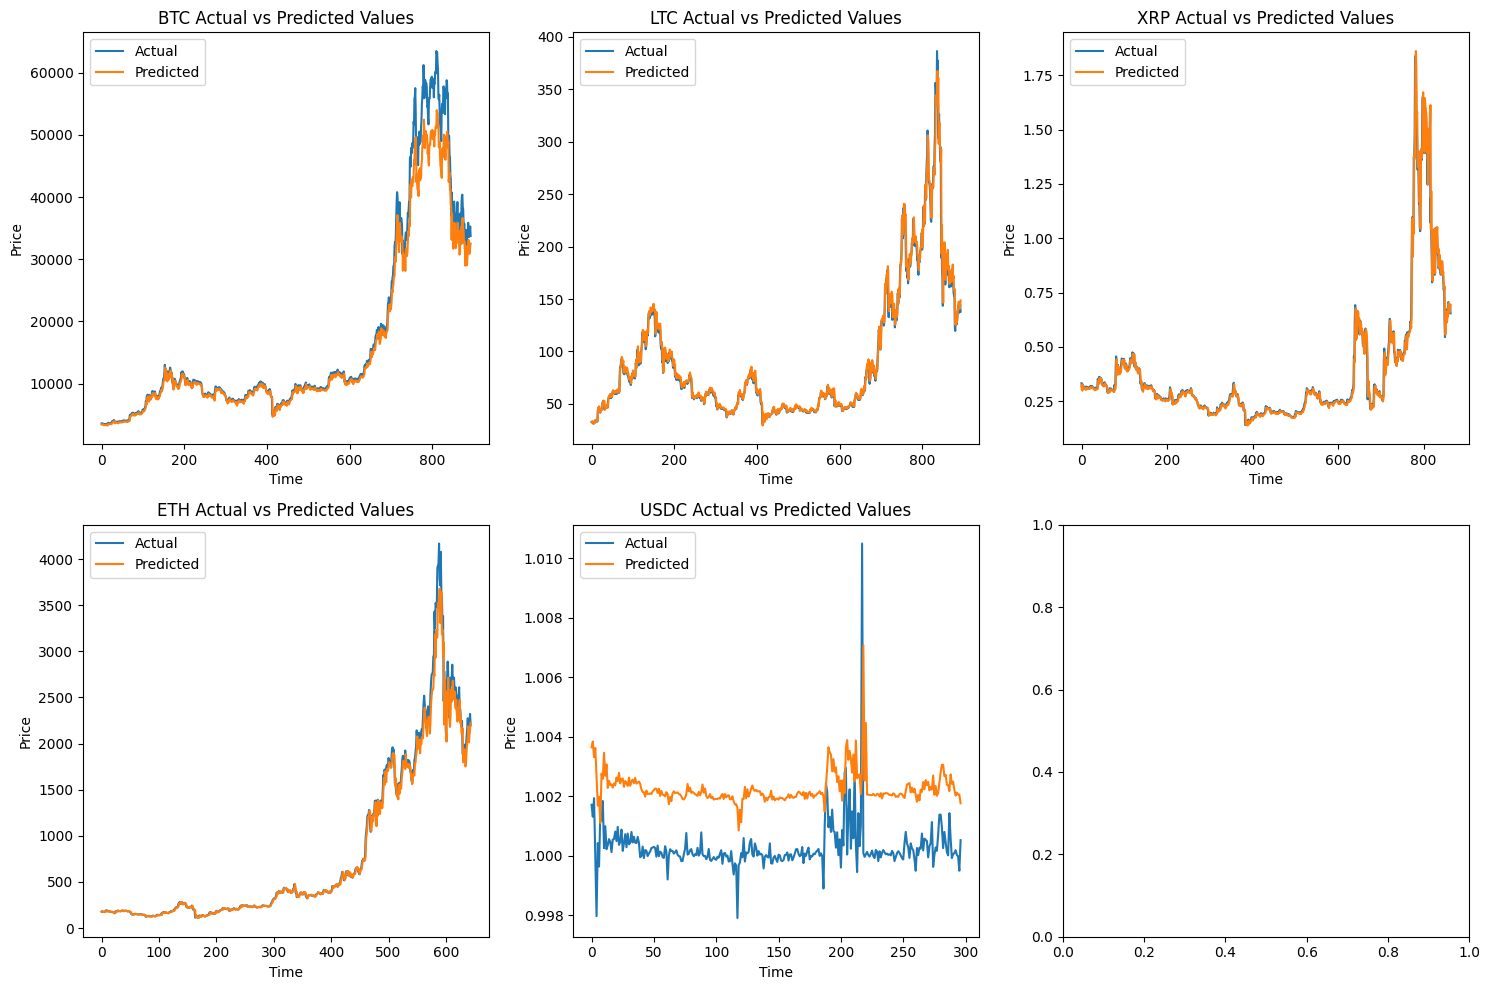

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Step 1: Data Preprocessing
btc_df = pd.read_csv("https://raw.githubusercontent.com/Amarpreet3/CIND-820-CAPSTONE/main/Dataset/coin_Bitcoin.csv")
eth_df = pd.read_csv("https://raw.githubusercontent.com/Amarpreet3/CIND-820-CAPSTONE/main/Dataset/coin_Ethereum.csv")
xrp_df = pd.read_csv("https://raw.githubusercontent.com/Amarpreet3/CIND-820-CAPSTONE/main/Dataset/coin_XRP.csv")
ltc_df = pd.read_csv("https://raw.githubusercontent.com/Amarpreet3/CIND-820-CAPSTONE/main/Dataset/coin_Litecoin.csv")
usdc_df = pd.read_csv("https://raw.githubusercontent.com/Amarpreet3/CIND-820-CAPSTONE/main/Dataset/coin_USDCoin.csv")

df = pd.concat([btc_df, eth_df, xrp_df, ltc_df, usdc_df])
df.to_csv("cryptocurrency.csv", index=False)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# create a list of unique tokens offered on the exchange
tokens = df['Symbol'].unique()

# create a dictionary to store the models and their performance metrics
models = {}

# create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# loop through each token and plot its actual vs predicted values on a subplot
for i, token in enumerate(tokens):
    # select the data for the current token
    data = df[df['Symbol'] == token]['Close'].values.reshape(-1, 1)

    # preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # split data into training and testing sets
    train_size = int(len(scaled_data) * 0.7)
    train_data = scaled_data[:train_size, :]
    test_data = scaled_data[train_size:, :]

    # function to create LSTM dataset
    def create_dataset(dataset, look_back=1):
        X, y = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            X.append(a)
            y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(y)

    # create training and testing data for LSTM model
    look_back = 3
    X_train, y_train = create_dataset(train_data, look_back)
    X_test, y_test = create_dataset(test_data, look_back)

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # create and train LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

    # make predictions on test data
    y_pred = model.predict(X_test)

    # inverse transform the scaled data
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler.inverse_transform(y_pred)

    # evaluate model using various performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    corr = np.corrcoef(y_pred.T, y_test.T)[0, 1]
    r2 = r2_score(y_test, y_pred)
     # add the model and its performance metrics to
    models[token] = {'model': model, 'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'corr': corr, 'r2': r2}

    # plot actual vs predicted values on a subplot
    row = i // 3
    col = i % 3
    axs[row, col].plot(y_test, label='Actual')
    axs[row, col].plot(y_pred, label='Predicted')
    axs[row, col].set_title('{} Actual vs Predicted Values'.format(token))
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Price')
    axs[row, col].legend()

        # create a table to display evaluation metrics for all models
    results = pd.DataFrame(columns=['Symbol', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Corr', 'R2'])
    for token, metrics in models.items():
        results = results.append({'Symbol': token,
                              'MSE': metrics['mse'],
                              'RMSE': metrics['rmse'],
                              'MAE': metrics['mae'],
                              'MAPE': metrics['mape'],
                              'Corr': metrics['corr'],
                              'R2': metrics['r2']}, ignore_index=True)

    # display results table
    print('\n\nEvaluation Metrics for All Tokens:')
    print(results)

# adjust subplot layout
plt.tight_layout()

# show plot
plt.show()

Epoch 1/100
2089/2089 - 8s - loss: 4.7855e-04 - 8s/epoch - 4ms/step
Epoch 2/100
2089/2089 - 8s - loss: 4.2742e-04 - 8s/epoch - 4ms/step
Epoch 3/100
2089/2089 - 7s - loss: 3.7551e-04 - 7s/epoch - 3ms/step
Epoch 4/100
2089/2089 - 8s - loss: 3.7266e-04 - 8s/epoch - 4ms/step
Epoch 5/100
2089/2089 - 8s - loss: 3.6982e-04 - 8s/epoch - 4ms/step
Epoch 6/100
2089/2089 - 6s - loss: 3.2878e-04 - 6s/epoch - 3ms/step
Epoch 7/100
2089/2089 - 7s - loss: 2.7835e-04 - 7s/epoch - 4ms/step
Epoch 8/100
2089/2089 - 6s - loss: 2.4778e-04 - 6s/epoch - 3ms/step
Epoch 9/100
2089/2089 - 7s - loss: 2.0077e-04 - 7s/epoch - 4ms/step
Epoch 10/100
2089/2089 - 6s - loss: 2.1733e-04 - 6s/epoch - 3ms/step
Epoch 11/100
2089/2089 - 7s - loss: 1.9398e-04 - 7s/epoch - 4ms/step
Epoch 12/100
2089/2089 - 7s - loss: 1.4820e-04 - 7s/epoch - 3ms/step
Epoch 13/100
2089/2089 - 7s - loss: 1.1840e-04 - 7s/epoch - 3ms/step
Epoch 14/100
2089/2089 - 7s - loss: 1.2836e-04 - 7s/epoch - 4ms/step
Epoch 15/100
2089/2089 - 7s - loss: 1.0452e

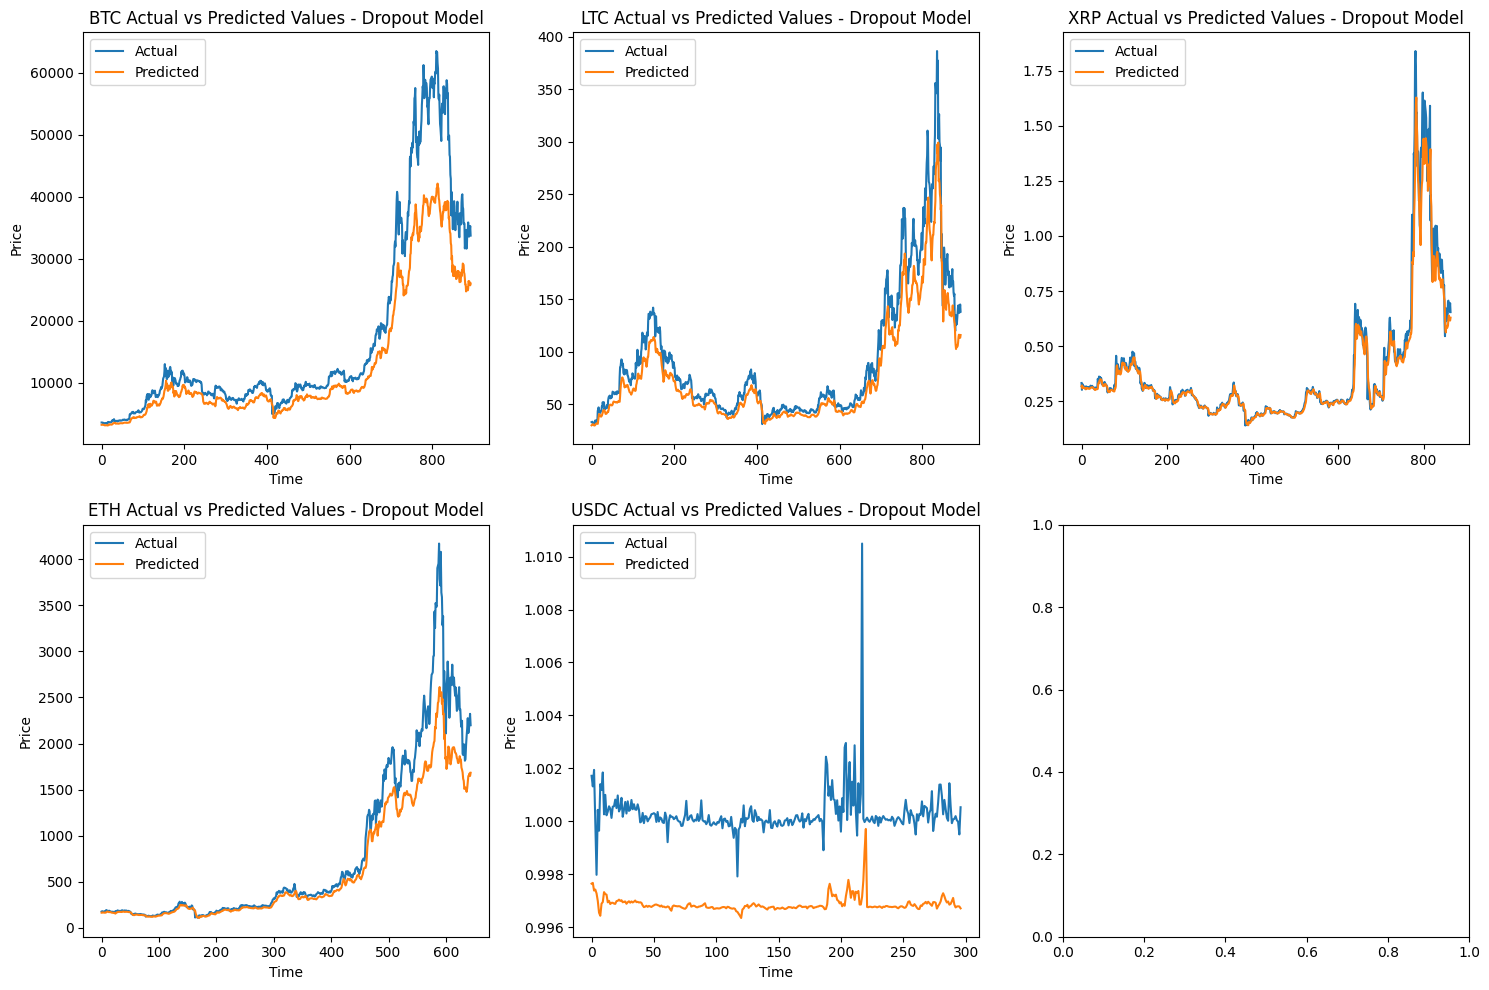

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Step 1: Data Preprocessing
btc_df = pd.read_csv("https://raw.githubusercontent.com/Amarpreet3/CIND-820-CAPSTONE/main/Dataset/coin_Bitcoin.csv")
eth_df = pd.read_csv("https://raw.githubusercontent.com/Amarpreet3/CIND-820-CAPSTONE/main/Dataset/coin_Ethereum.csv")
xrp_df = pd.read_csv("https://raw.githubusercontent.com/Amarpreet3/CIND-820-CAPSTONE/main/Dataset/coin_XRP.csv")
ltc_df = pd.read_csv("https://raw.githubusercontent.com/Amarpreet3/CIND-820-CAPSTONE/main/Dataset/coin_Litecoin.csv")
usdc_df = pd.read_csv("https://raw.githubusercontent.com/Amarpreet3/CIND-820-CAPSTONE/main/Dataset/coin_USDCoin.csv")

df = pd.concat([btc_df, eth_df, xrp_df, ltc_df, usdc_df])
df.to_csv("cryptocurrency.csv", index=False)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# create a list of unique tokens offered on the exchange
tokens = df['Symbol'].unique()

# create a dictionary to store the models and their performance metrics
models = {}

# create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# loop through each token and plot its actual vs predicted values on a subplot
for i, token in enumerate(tokens):
    # select the data for the current token
    data = df[df['Symbol'] == token]['Close'].values.reshape(-1, 1)

    # preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # split data into training and testing sets
    train_size = int(len(scaled_data) * 0.7)
    train_data = scaled_data[:train_size, :]
    test_data = scaled_data[train_size:, :]

    # function to create LSTM dataset
    def create_dataset(dataset, look_back=1):
        X, y = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            X.append(a)
            y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(y)

    # create training and testing data for LSTM model
    look_back = 3
    X_train, y_train = create_dataset(train_data, look_back)
    X_test, y_test = create_dataset(test_data, look_back)

    # reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # create and train LSTM model with dropout layer
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1), dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

    # make predictions on test data
    y_pred = model.predict(X_test)

    # inverse transform the scaled data
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred = scaler.inverse_transform(y_pred)

    # evaluate model using various performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    corr = np.corrcoef(y_pred.T, y_test.T)[0, 1]
    r2 = r2_score(y_test, y_pred)
    # add the model and its performance metrics to
    models[token] = {'model': model, 'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'corr': corr, 'r2': r2}

        # plot actual vs predicted values on a subplot
    row = i // 3
    col = i % 3
    axs[row, col].plot(y_test, label='Actual')
    axs[row, col].plot(y_pred, label='Predicted')
    axs[row, col].set_title('{} Actual vs Predicted Values - Dropout Model'.format(token))
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Price')
    axs[row, col].legend()

    # evaluate model using various performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    corr = np.corrcoef(y_pred.T, y_test.T)[0, 1]
    r2 = r2_score(y_test, y_pred)

    # add the model and its performance metrics to
    models[token] = {'model': model, 'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'corr': corr, 'r2': r2}

    # create a table to display evaluation metrics for all models
    results = pd.DataFrame(columns=['Symbol', 'MSE', 'RMSE', 'MAE', 'MAPE', 'Corr', 'R2'])
    for token, metrics in models.items():
        results = results.append({'Symbol': token,
                              'MSE': metrics['mse'],
                              'RMSE': metrics['rmse'],
                              'MAE': metrics['mae'],
                              'MAPE': metrics['mape'],
                              'Corr': metrics['corr'],
                              'R2': metrics['r2']}, ignore_index=True)

    # display results table
    print('\n\nEvaluation Metrics for All Tokens: Dropout Model')
    print(results)

# adjust subplot layout
plt.tight_layout()

# show plot
plt.show()